In [11]:
from astropy.io import fits
from astropy import wcs
import bz2
import os
import urllib.request
import numpy as np
import copy
import matplotlib.pyplot as plt
import csv

In [12]:
def asymmetry(ra, dec, r, petrorad, expab, expphi, run, camcol, field, rowf, colf, FITS_directory='Fits files/'  ,rerun=301):
    #Returns an array of the fourier A1 parameter and the phase angle for a given object in the SDSS field specified
    #by run, rerun, camcol, field, row, col @ row, col.
    #r= Array of Radiuss to probe (in number of petrosian radiuses) to calculate the fourier coefficient for
    #petrorad=the petrosian radius of the object in arcseconds
    #expphi = The angle of the exponential fit, expressed as degrees, N through E
    #expAB= The ratio of the semi major axes of the disk
    # Run, rerun, camcol, field = Specified the SDSS field the object is contained in
    # rowf, colf = the pixel coordinates of the centre of the image, in FITS coordinates (ie, first pixel is 1, not zero) 
    # FITS_directory=Location of folder of fits files
    #Open FITS file from disk
    try:
        #Generate the name the FITS file will be stored under
        runstring='0'*(6-len(str(run)))+str(run) 
        fieldstring='0'*(4-len(str(field)))+str(field)
        fitsname='frame-i-'+runstring+'-'+str(camcol)+'-'+fieldstring
        #Try to open the fits file. If it throws a filenotfound error, it's because this field hasn't been downloaded yet
        file=fits.open(FITS_directory+fitsname+'.fits')
    except FileNotFoundError:
        #Generate the URL the zipped FITS file will be stored under
        fitsurl='http://data.sdss3.org/sas/dr12/boss/photoObj/frames/'+str(rerun)+'/'+str(run)+'/'+str(camcol)+'/'+fitsname+'.fits.bz2'
        print('Downloading from ', fitsurl)
        #Save the zipped FITS file, extract the unzipped fits file
        urllib.request.urlretrieve(fitsurl, FITS_directory+fitsname+'.fits.bz2')
        f=bz2.open(FITS_directory+fitsname+'.fits.bz2')
        #Save the unzipped FITS file to disk
        save=fits.open(f)
        save.writeto(FITS_directory+fitsname+'.fits')
        save.close()
        #Remove the zipped file to save space
        os.remove(FITS_directory+fitsname+'.fits.bz2')
        file=fits.open(FITS_directory+fitsname+'.fits')
    image=file[0] 
    data=image.data
    output=[]
    
    #If user has entered single radius, converts this to list so can be iterated over later
    if type(r)==float or type(r)==int:
        r=[r]
    #Convert centre row and column to python convention (starting at zero), instead of FITS convention(starting at 1)
    rowc=rowf-1
    colc=colf-1
    
    
    #Get coordinate parameters from header using astropy WCS class. 
    coords=wcs.WCS(image.header)
    
    #Checks ra & dec agree with FITS header to within 1 pixel. 
    checkradec(ra, dec, coords, rowc, colc)
    
    #Set up sub-function to return row, col pairs for given ra, dec values
    def pix(raf,decf):
        #Takes values of ra and dec (in degrees). Converts to an array of [row, col] in pixel values
        array=coords.all_world2pix(raf,decf,0)
        return array[::-1]
    

    #Get length of semi-major and semi-minor axes of petrosian ellipse. Assume petrosian radius is the geometric mean of a & b. In degrees
    a=(2./(1+expab**2))**0.5*petrorad/3600.
    b=(2./(1+expab**-2))**0.5*petrorad/3600.
    
    
   
    
    
    #Create an array of theta values to sample the ellipse at
    dtheta=360./360.
    thetas=np.arange(0,360,dtheta)
    thetarad=[i*2*np.pi/360. for i in thetas]
    for relement in r: 
        #Get semi-major and semi-minor axes of the ellipse to calculate the fourier coefficients around. In arcsec
        ar=a*relement
        br=b*relement
        rs=getrs(thetas, ar, br, expphi)
        #Create array with data values for each theta, r combination
        pixbrightness=[]
        for i in range(len(thetas)):
            #Calculate ra, dec values of target
            #First calculate distances from centre
            drai=rs[i]*np.sin(thetarad[i])
            ddeci=rs[i]*np.cos(thetarad[i])
            #Then add on coordinates of centre
            rai=ra+drai
            deci=dec+ddeci

            #Convert to pixels
            pixel=pix(rai,deci)
            rowi=float(pixel[0])
            coli=float(pixel[1])
            rowiround=int(round(rowi))
            coliround=int(round(coli))
            pixbrightness.append(data[rowiround, coliround])


        #Weight the pixel brightnesses by cos(theta) and sin(theta)
        brightnesssin=[pixbrightness[i]*np.sin(thetarad[i]) for i in range(len(thetarad))]
        brightnesscos=[pixbrightness[i]*np.cos(thetarad[i]) for i in range(len(thetarad))]
        #Find the a1 & b1 fourier coefficients. 1/pi * integral over pixelbrighness sin/cos (integrated using np.trapz). f(x)=ancosntheta+ bnsinntheta, summed over all n
        a1=np.pi**-1*np.trapz(brightnesscos, thetarad)
        b1=np.pi**-1*np.trapz(brightnesssin, thetarad)
        a0=np.pi**-1*np.trapz(pixbrightness, thetarad)
        #Now find fourier coefficients in the form f(x)=Ancos(ntheta-phi)
        A1=(a1**2+b1**2)**0.5
        phi=np.arctan(-a1/b1)
        output.append([A1, phi*360./2/np.pi, A1/a0, a0])
    return output
    file.close()
    
    
    
def ellipse(a,b,theta,phi):
    #returns the r coordinate of the ellipse with:
    #semi major axes a,b at polar angle theta degrees (measured from north, through east),
    #with semi-major axis offset from north by phi degrees (measured from north through east)
    thetarad=theta*2*np.pi/360.
    phirad=phi*2*np.pi/360.
    r=a*b/((b*np.cos(thetarad-phirad))**2+(a*np.sin(thetarad-phirad))**2)**0.5
    return r

def checkradec(ra, dec, coords, row, col):
    #checks to see if the pixel coordinates returned by a WCS object coords match ra and dec to correct values row and column
    reportedrow=coords.all_world2pix(ra,dec,0)[1]
    reportedcol=coords.all_world2pix(ra,dec,0)[0]
    try:
        if (reportedcol-col)**2>1 or (reportedrow-row)**2>1:
            raise ValueError('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', reportedrow-row, 'Column discrepancy is', reportedcol-col)
    except ValueError:
        pass
def getrs(thetas, a, b, phi):
    rs=[]
    for i in thetas:
        rs.append(ellipse(a,b,i,phi))
    return rs
def functionchecker(ra, dec, r, petrorad, expab, expphi, run, camcol, field, rowf, colf, A1, A0, phi, FITS_directory='Fits files/'  ,rerun=301, A2=0.2, A3=0.14):
    #Opens the fits file for the given galaxy coordinates, then edits it to make the specific fourier components A1 and phi at radius r petrorads
       #Creates a fits file with an ellipse drawn on at r petrosian radii for a given object in the SDSS field specified
    #by run, rerun, camcol, field, row, col @ row, col.
    #r= Radius (in number of petrosian radiuses) to calculate the fourier coefficient for
    #petrorad=the petrosian radius of the object in arcseconds
    #expphi = The angle of the exponential fit, expressed as degrees, N through E
    #expAB= The ratio of the semi major axes of the disk
    # Run, rerun, camcol, field = Specified the SDSS field the object is contained in
    # rowf, colf = the pixel coordinates of the centre of the image, in FITS coordinates (ie, first pixel is 1, not zero) 
    #A1, A0, phi(degrees) - first fourier coefficients
    # FITS_directory=Location of folder of fits files
    #Open FITS file from disk
    try:
        #Generate the name the FITS file will be stored under
        runstring='0'*(6-len(str(run)))+str(run) 
        fieldstring='0'*(4-len(str(field)))+str(field)
        fitsname='frame-i-'+runstring+'-'+str(camcol)+'-'+fieldstring
        #Try to open the fits file. If it throws a filenotfound error, it's because this field hasn't been downloaded yet
        file=fits.open(FITS_directory+fitsname+'.fits')
    except FileNotFoundError:
        #Generate the URL the zipped FITS file will be stored under
        fitsurl='http://data.sdss3.org/sas/dr12/boss/photoObj/frames/'+str(rerun)+'/'+str(run)+'/'+str(camcol)+'/'+fitsname+'.fits.bz2'
        #Save the zipped FITS file, extract the unzipped fits file
        urllib.request.urlretrieve(fitsurl, FITS_directory+fitsname+'.fits.bz2')
        f=bz2.open(FITS_directory+fitsname+'.fits.bz2')
        #Save the unzipped FITS file to disk
        save=fits.open(f)
        save.writeto(FITS_directory+fitsname+'.fits')
        save.close()
        #Remove the zipped file to save space
        os.remove(FITS_directory+fitsname+'.fits.bz2')
        file=fits.open(FITS_directory+fitsname+'.fits')
    image=file[0]
    data=image.data
    
    #Convert centre row and column to python convention (starting at zero), instead of FITS convention(starting at 1)
    rowc=rowf-1
    colc=colf-1
    
    
    #Get coordinate parameters from header using astropy WCS class. 
    coords=wcs.WCS(image.header)
    
    #Checks ra & dec agree with FITS header to within 1 pixel. 
    checkradec(ra, dec, coords, rowc, colc)
    
    #Set up sub-function to return row, col pairs for given ra, dec values
    def pix(raf,decf):
        #Takes values of ra and dec (in degrees). Converts to an array of [row, col] in pixel values
        array=coords.all_world2pix(raf,decf,0)
        return array[::-1]
    

    #Get length of semi-major and semi-minor axes of petrosian ellipse. Assume petrosian radius is the geometric mean of a & b. In degrees
    a=(2./(1+expab**2))**0.5*petrorad/3600.
    b=(2./(1+expab**-2))**0.5*petrorad/3600.
    
    #Get semi-major and semi-minor axes of the ellipse to calculate the fourier coefficients around. In arcsec
    ar=a*r
    br=b*r
    
    
    #Create an array of theta values to sample the ellipse at
    dtheta=360./3600.
    thetas=np.arange(0,360,dtheta)
    rs=getrs(thetas, ar, br, expphi)
    
    def fourier(thetar, An, phi, n):
        return An*np.sin(n*(thetar-phi*2*np.pi/360))
    #Change value of each pixel in ellipse in ellipselayer
    for i in range(len(thetas)):
        thetarad=thetas[i]*2*np.pi/360.
        #Calculate ra, dec values of target
        #First calculate distances from centre
        drai=rs[i]*np.sin(thetarad)
        ddeci=rs[i]*np.cos(thetarad)
        #Then add on coordinates of centre
        rai=ra+drai
        deci=dec+ddeci
        
        #Convert to pixels
        pixel=pix(rai,deci)
        rowi=float(pixel[0])
        coli=float(pixel[1])
        rowiround=int(round(rowi))
        coliround=int(round(coli))
        #Sets corresponding pixel to value 2
        data[rowiround,coliround]=fourier(thetarad,A1,phi,1)+fourier(thetarad,A2,phi,2)+fourier(thetarad,A3,phi,3)+A0/2.
    #Adds the layer to the original fits file and saves as a new fits file with camcol G (for generated) (to differentiate between real and generated fits files)
    newfilename='frame-i-'+runstring+'-G'+'-'+fieldstring
    file.writeto(FITS_directory+newfilename+'.fits')
   
    file.close()

In [657]:
#Standard disk galaxy
print(asymmetry(211.6933,-0.7880827,[0.5,1],11.10158,0.7288934,67.95884,752,2,455,855.3524,543.3588))
#functionchecker(211.6933,-0.7880827,0.5,11.10158,0.7288934,67.95884,752,2,455,855.3524,543.3588, 0.2,0.34,67.95)
#Generated with A1=0.2, A0=0.34
print(asymmetry(211.6933,-0.7880827,0.5,11.10158,0.7288934,67.95884,752,'G',455,855.3524,543.3588))
#2 ellipticals
print(asymmetry(ra=183.1636,dec=-2.72125371210762,r=1,petrorad=5.679752,expab=0.6782587,expphi=15.41315,run=1231, camcol=3, field=93, rowf=575.2551, colf=1835.075))
print(asymmetry(177.674618283769,32.6972439603947,1,11.14533,0.8839771,138.7685,4599,4,60,599.2166,1872.716))

[[0.023043034491257851, 25.142408354507168, 0.10132276799269167, 0.22742207845052087], [0.05808923879572412, -69.513839441406077, 0.41463860026967969, 0.14009607103135852]]
[[0.19888016583700563, 66.681587148523434, 0.58617043471629959, 0.33928726878431109]]
[[0.023296133095775235, -25.837470722475, 0.02385941568781921, 0.97639160156249993]]
[[0.0012145048809895794, -2.4618547254541965, 0.0025651567214023869, 0.47346225314670137]]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [13]:
def a1a0array(filename, radius):
    #Returns a list of A1/A0 values of the galaxies contained in filename at r petrosian radii
    #CSV file must have galaxies on each row, with the following column order: ra1, dec1, ra2, dec2, objid, distance, petrorad, expad, expphi,run,rerun,camcol, field, rowc, colc
    
    #Set up lists to hold data
    ras=[]
    decs=[]
    petrorads=[]
    expabs=[]
    phis=[]
    runs=[]
    camcols=[]
    fields=[]
    rowcs=[]
    colcs=[]
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        #Gets data on everything except 1st row
        colnames=next(reader)
        for row in reader:
            ras.append(float(row[2]))
            decs.append(float(row[3]))
            petrorads.append(float(row[6]))
            expabs.append(float(row[7]))
            phis.append(float(row[8]))
            runs.append(row[9])
            camcols.append(row[11])
            fields.append(row[12])
            rowcs.append(float(row[13]))
            colcs.append(float(row[14]))
    #Create list to hold results
    a1a0s=[]
    for i in range(len(ras)):
        print(i)
        try:
            asymmetryallrs=asymmetry(ra=ras[i], dec=decs[i], r=radius, petrorad=petrorads[i], expab=expabs[i], expphi=phis[i], run=runs[i], camcol=camcols[i], field=fields[i], rowf=rowcs[i], colf=colcs[i])
            a1a0s.append([asymmetryallrs[j][2] for j in range(len(asymmetryallrs))])
        except ValueError as exc:
            print(exc)
            continue
        except IndexError as exc:
            #If galaxy is too close to the edge, get index error. In this case, just append the average value of the list so far(important for calculating averages over ranges of radii later)
            a1a0s.append(np.mean(a1a0s))
            print(exc)
            continue
    #Alter a1a0s to look like before
    a1a0scorrected=[]
    for k in range(len(a1a0s[0])):
        a1a0scorrected.append([a1a0s[l][k] for l in range(len(a1a0s))])
    return a1a0scorrected    
        

In [14]:
def plotellipse(ra, dec, r, petrorad, expab, expphi, run, camcol, field, rowf, colf, FITS_directory='Fits files/'  ,rerun=301):
    #Creates a fits file with an ellipse drawn on at r petrosian radii for a given object in the SDSS field specified
    #by run, rerun, camcol, field, row, col @ row, col.
    #r= Radius (in number of petrosian radiuses) to calculate the fourier coefficient for
    #petrorad=the petrosian radius of the object in arcseconds
    #expphi = The angle of the exponential fit, expressed as degrees, N through E
    #expAB= The ratio of the semi major axes of the disk
    # Run, rerun, camcol, field = Specified the SDSS field the object is contained in
    # rowf, colf = the pixel coordinates of the centre of the image, in FITS coordinates (ie, first pixel is 1, not zero) 
    # FITS_directory=Location of folder of fits files
    #Open FITS file from disk
    try:
        #Generate the name the FITS file will be stored under
        runstring='0'*(6-len(str(run)))+str(run) 
        fieldstring='0'*(4-len(str(field)))+str(field)
        fitsname='frame-i-'+runstring+'-'+str(camcol)+'-'+fieldstring
        #Try to open the fits file. If it throws a filenotfound error, it's because this field hasn't been downloaded yet
        file=fits.open(FITS_directory+fitsname+'.fits')
    except FileNotFoundError:
        #Generate the URL the zipped FITS file will be stored under
        fitsurl='http://data.sdss3.org/sas/dr12/boss/photoObj/frames/'+str(rerun)+'/'+str(run)+'/'+str(camcol)+'/'+fitsname+'.fits.bz2'
        #Save the zipped FITS file, extract the unzipped fits file
        urllib.request.urlretrieve(fitsurl, FITS_directory+fitsname+'.fits.bz2')
        f=bz2.open(FITS_directory+fitsname+'.fits.bz2')
        #Save the unzipped FITS file to disk
        save=fits.open(f)
        save.writeto(FITS_directory+fitsname+'.fits')
        save.close()
        #Remove the zipped file to save space
        os.remove(FITS_directory+fitsname+'.fits.bz2')
        file=fits.open(FITS_directory+fitsname+'.fits')
    image=file[0]
    data=image.data
    #Set up new layer with same shape as image data, with value -100 in all pixels
    ellipselayer=copy.copy(file[0])
    ellipselayer.data=np.full_like(ellipselayer.data,-100.)
    

    #Convert centre row and column to python convention (starting at zero), instead of FITS convention(starting at 1)
    rowc=rowf-1
    colc=colf-1
    
    
    #Get coordinate parameters from header using astropy WCS class. 
    coords=wcs.WCS(image.header)
    
    #Checks ra & dec agree with FITS header to within 1 pixel. 
    checkradec(ra, dec, coords, rowc, colc)
    
    #Set up sub-function to return row, col pairs for given ra, dec values
    def pix(raf,decf):
        #Takes values of ra and dec (in degrees). Converts to an array of [row, col] in pixel values
        array=coords.all_world2pix(raf,decf,0)
        return array[::-1]
    

    #Get length of semi-major and semi-minor axes of petrosian ellipse. Assume petrosian radius is the geometric mean of a & b. In degrees
    a=(2./(1+expab**2))**0.5*petrorad/3600.
    b=(2./(1+expab**-2))**0.5*petrorad/3600.
    
    #Get semi-major and semi-minor axes of the ellipse to calculate the fourier coefficients around. In arcsec
    ar=a*r
    br=b*r
    
    
    #Create an array of theta values to sample the ellipse at
    dtheta=360./360.
    thetas=np.arange(0,360,dtheta)
    rs=getrs(thetas, ar, br, expphi)
    
    #Change value of each pixel in ellipse in ellipselayer
    for i in range(len(thetas)):
        thetarad=thetas[i]*2*np.pi/360.
        #Calculate ra, dec values of target
        #First calculate distances from centre
        drai=rs[i]*np.sin(thetarad)
        ddeci=rs[i]*np.cos(thetarad)
        #Then add on coordinates of centre
        rai=ra+drai
        deci=dec+ddeci
        
        #Convert to pixels
        pixel=pix(rai,deci)
        rowi=float(pixel[0])
        coli=float(pixel[1])
        rowiround=int(round(rowi))
        coliround=int(round(coli))
        #Sets corresponding pixel to value 2
        ellipselayer.data[rowiround,coliround]=2.
        data[rowiround,coliround]=2.
    #Adds the layer to the original fits file and saves as a new fits file
    file.append(ellipselayer)
    file.writeto(FITS_directory+fitsname+'_with_ellipse_at_'+str(r)+'_petrorad'+'.fits')
   
    file.close()

In [339]:
plotellipse(211.6933,-0.7880827,1,11.10158,0.7288934,67.95884,752,2,455,855.3524,543.3588)

Filename: Fits files/frame-i-000752-2-0455.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   
  4                1 ImageHDU        85   (2048, 1489)   float32   
None


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [440]:
ellipticals=a1a0array('downloads/Elliptical_Data_for_asymetry4_aa2811.csv', 1)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.52590816394922513, 'Column discrepancy is', 1.3793871971268743)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.82574838861205535, 'Column discrepancy is', 1.2490815207543164)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 1.5287056225438391, 'Column discrepancy is', 0.46920893994479229)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 1.4950829529055909, 'Column discrepancy is', 0.37891747207231674)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.52520666796522164, 'Column discrepancy is', 1.44744335768155)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.41457967989822464, 'Column discrepancy is', 1.4662908559623702)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 1.4362579946027836, 'Column discrepancy is', 0.46631411554176339)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.50000826373991458, 'Column discrepancy is', 1.5467386782020185)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.54060270665479493, 'Column discrepancy is', 1.6823035054537741)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.47222135863779613, 'Column discrepancy is', 1.5282440948541307)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.25121813754117284, 'Column discrepancy is', 1.50755441239221)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 1.5257673102771605, 'Column discrepancy is', 0.38503075285643718)


('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.51536705175300312, 'Column discrepancy is', 1.4845043552747939)
('Coordinates from PhotoObj and ra & dec values do not match. Row discrepancy is ', 0.56811966868508534, 'Column discrepancy is', 1.4864881861541335)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


index 2053 is out of bounds for axis 1 with size 2048
index 1489 is out of bounds for axis 0 with size 1489
index 2052 is out of bounds for axis 1 with size 2048
index 2048 is out of bounds for axis 1 with size 2048
index 1489 is out of bounds for axis 0 with size 1489


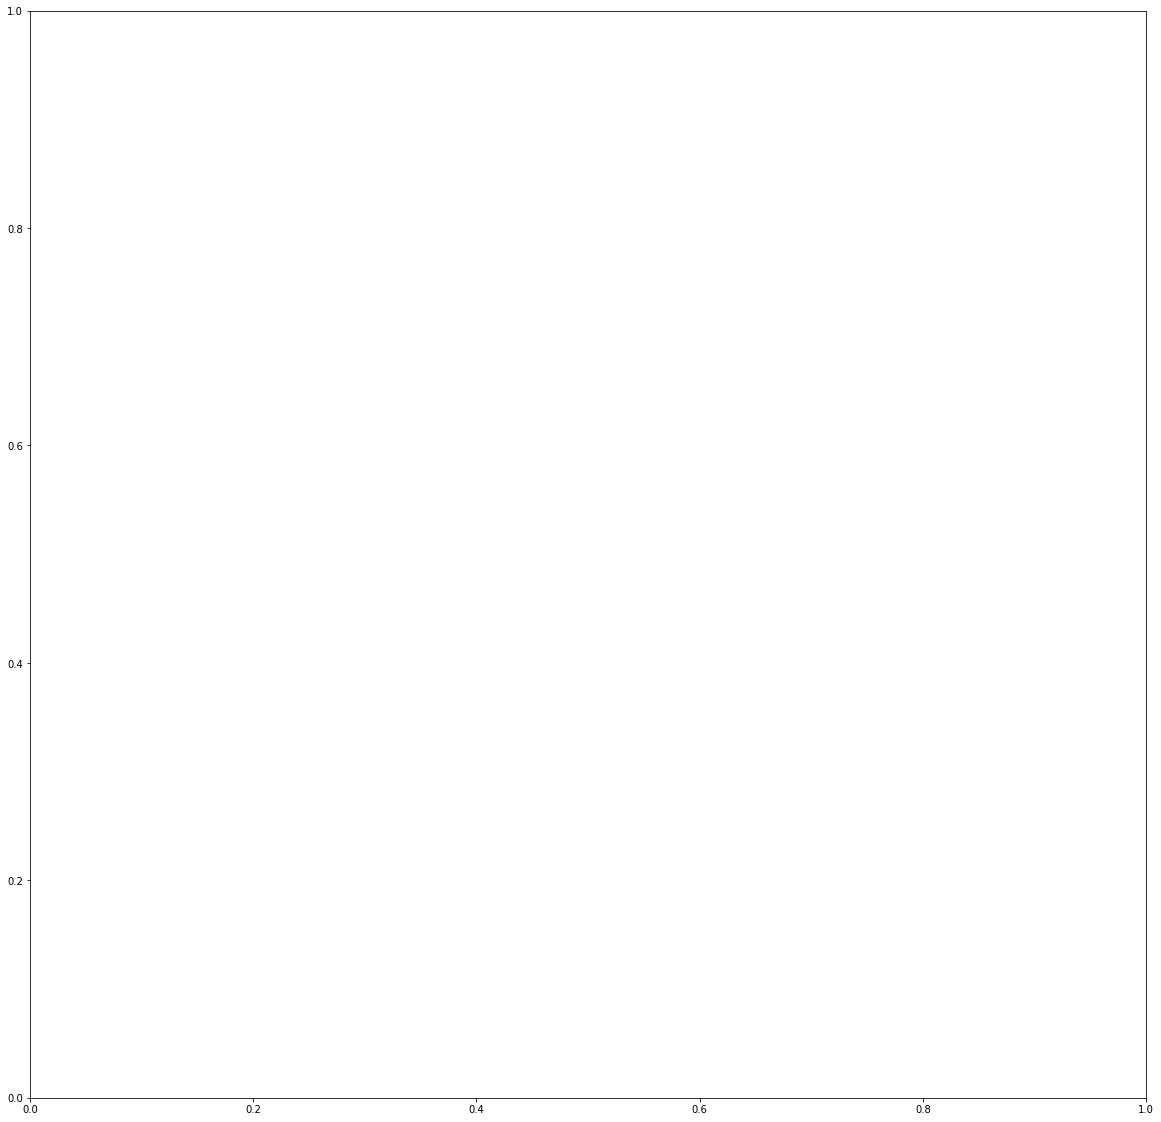

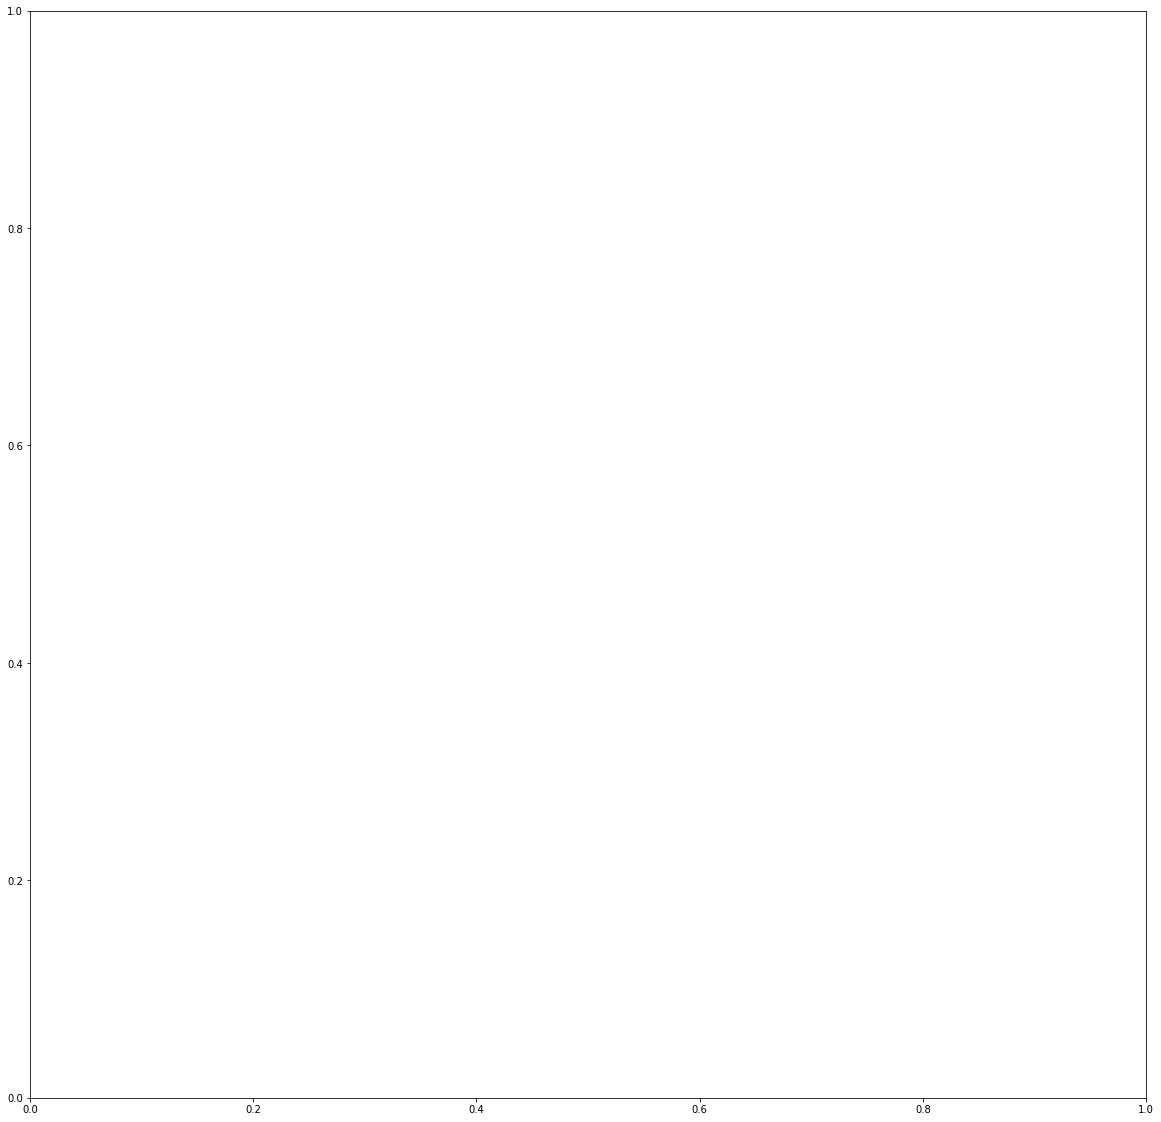

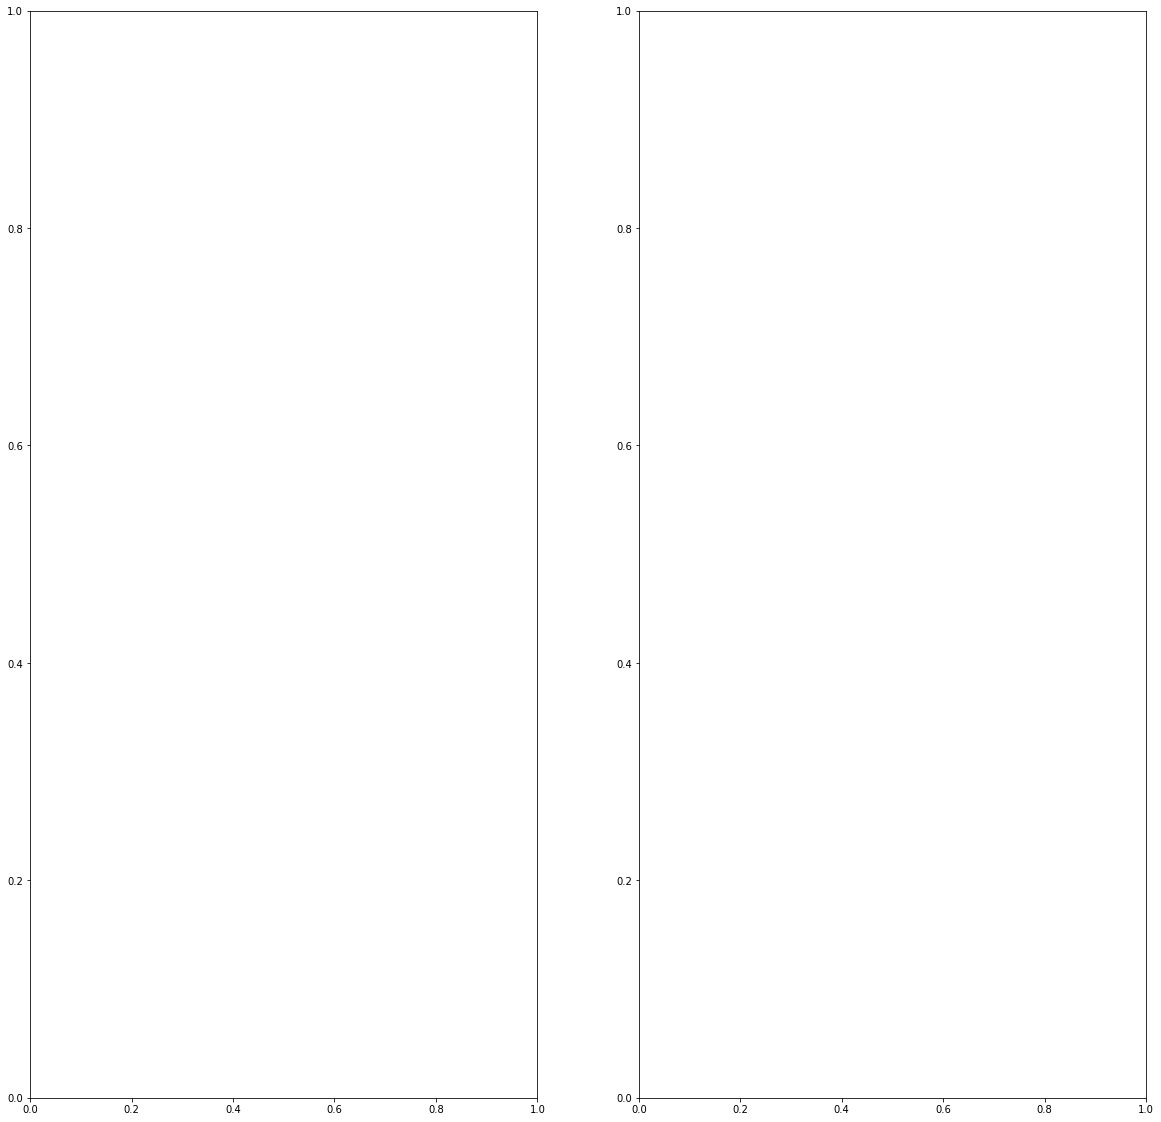

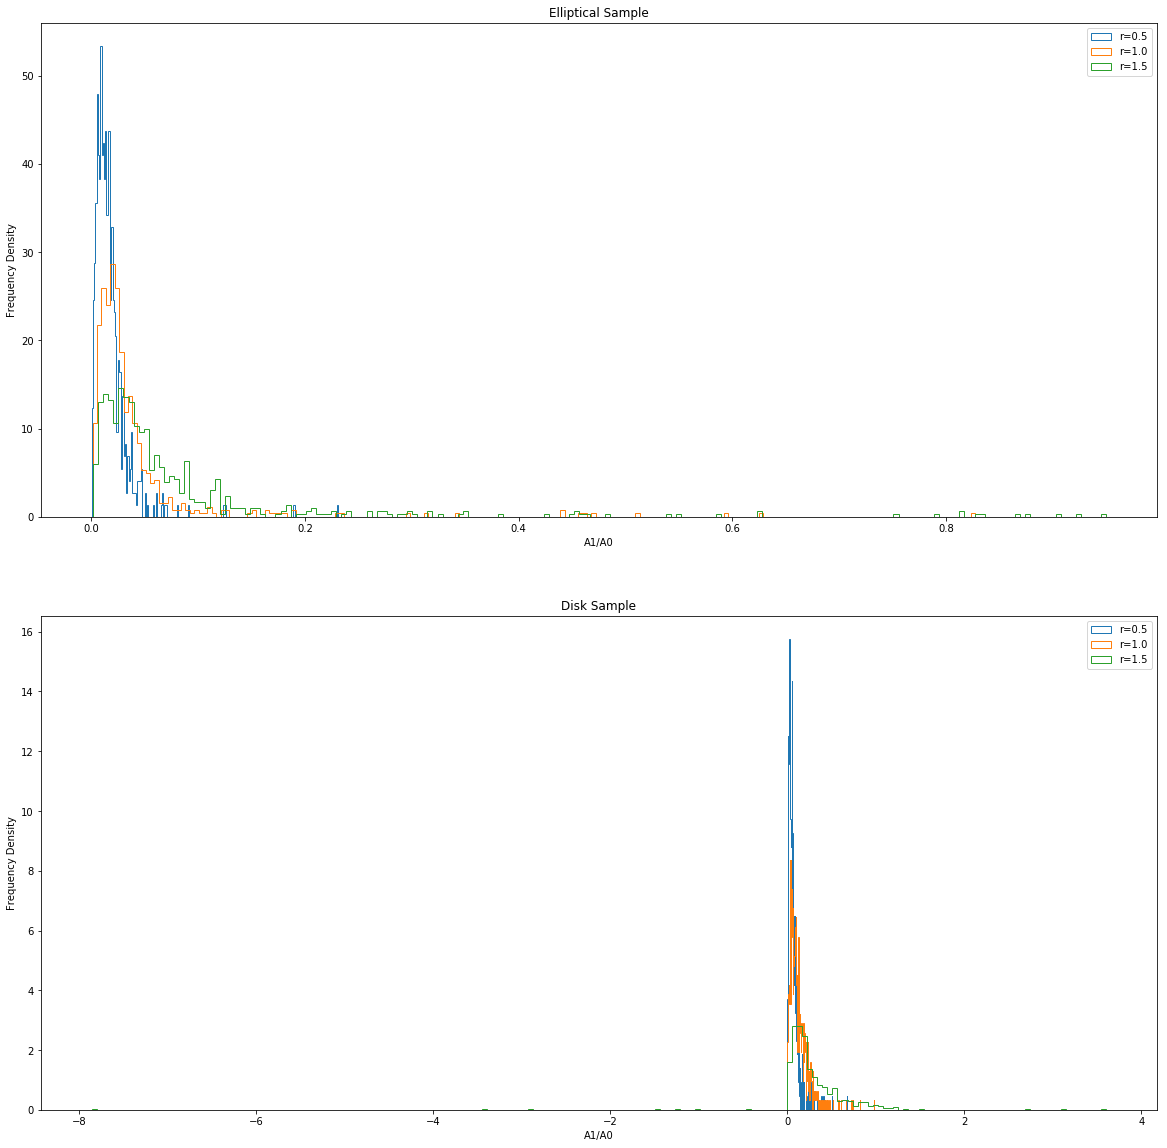

In [475]:
fig, (ax1,ax2)=plt.subplots(nrows=2, figsize=(20,20))
for r in np.arange(0.5,1.6,0.5):
    ellipticalstemp=a1a0array('downloads/Elliptical_Data_for_asymetry4_aa2811.csv', r)
    ax1.hist(ellipticalstemp,200, histtype='step', density=True, label='r='+str(r))
    disktemp=a1a0array('downloads/Disk_sample635_aa2811.csv', r)
    ax2.hist(disktemp,200, histtype='step', density=True, label='r='+str(r))


ax1.set_xlabel('A1/A0')
ax1.set_ylabel('Frequency Density')
ax1.set_title('Elliptical Sample')
ax1.legend()
ax2.set_xlabel('A1/A0')
ax2.set_ylabel('Frequency Density')
ax2.set_title('Disk Sample')
ax2.legend()
plt.show()

In [679]:
rtoprobe=np.arange(0.1,0.11,0.01)
disksamplers2=a1a0array('downloads/Disk_sample635_aa2811.csv', rtoprobe)
ellipticalsamplers2=a1a0array('downloads/Elliptical_Data_for_asymetry4_aa2811.csv', rtoprobe)



0
1
2
3

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



4
5
6
7
8
9
10


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245


246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495


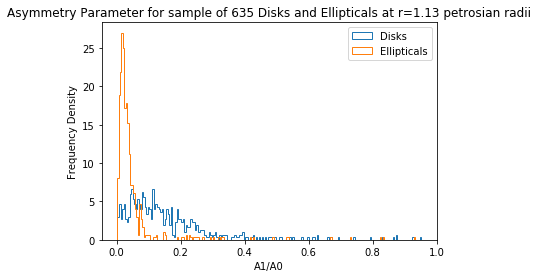

In [638]:
plt.hist(disksamplers[103], 200, density=True,histtype='step', label='Disks')
plt.hist(ellipticalsamplers[103],200, density=True,histtype='step', label='Ellipticals')
plt.xlabel('A1/A0')
plt.ylabel('Frequency Density')
plt.title('Asymmetry Parameter for sample of 635 Disks and Ellipticals at r=1.13 petrosian radii')
plt.legend()
plt.show()

In [32]:
def areabetween(list1,list2, bins=200):
    #Returns the integral of the square of the difference between the histograms described by the data in list 1 & 2
    #Finds the appropriate bounds of the histogram
    minbound=min(list1+list2)
    maxbound=max(list1+list2)
    #Bins the data and returns an array of frequency density and bin edges
    hist1=np.histogram(list1, bins, range=(minbound,maxbound), density=True)
    hist2=np.histogram(list2,bins, range=(minbound,maxbound), density=True)
    #Works out the square of the difference between the two distributions
    diffrms=[((hist1[0][i]-hist2[0][i])**2)**0.5 for i in range(len(hist2[0]))]
    bins=[(hist1[1][i]+hist1[1][i+1])*0.5 for i in range(len(hist1[1])-1)]
    integral=np.trapz(diffrms, bins)
    return integral
    
def averageover(starti,endi, listoflists):
    #Takes a list of lists of asymmetrys for different values of r, and averages between the values starti and endi
    totallist=listoflists[starti][:]
    if endi-starti>0:
        try:
            for i in range(starti+1,endi+1):
                for j in range(len(totallist)):
                    totallist[j]=totallist[j]+listoflists[i][j]
        except IndexError:
            print(i,j)
    averagelist=[k/float(endi-starti+1) for k in totallist]
    return averagelist

                                                                     

In [634]:
#Go through each r probed and find the one where the two populations are least overlapping
maxareabetween=0
maaxr=0
for i in range(len(rtoprobe)):
    if areabetween(disksamplers[i], ellipticalsamplers[i])>maxareabetween:
        maxareabetween=areabetween(disksamplers[i], ellipticalsamplers[i])
        maxr=rtoprobe[i]
        maxi=i
    
print(maxr, maxareabetween, maxi)


1.13 1.30787401575 103


In [632]:
#Go through each pair of starti's and endi's to find with range of rs are least overlapping
maxareabetween2=0
maxstarti=0
maxendi=0
maxrmin=0
maxrmax=0
#i is starti, j is endi
for i in range(len(rtoprobe)):
    for j in range(i, len(rtoprobe)):
        diskaverage=averageover(i,j,disksamplers)
        ellipticalaverage=averageover(i,j,ellipticalsamplers)
        print(i,j,areabetween(diskaverage, ellipticalaverage))
        if areabetween(diskaverage, ellipticalaverage)>maxareabetween2:
            maxareabetween2=areabetween(diskaverage, ellipticalaverage)
            maxrmin=rtoprobe[i]
            maxrmax=rtoprobe[j]
            maxstarti=i
            maxendi=j
            print(maxrmin, maxrmax, maxstarti, maxendi, maxareabetween2)
print(maxrmin, maxrmax, maxstarti, maxendi, maxareabetween2)

0 0 0.409448818898
0.1 0.1 0 0 0.409448818898
0 1 0.433070866142
0.1 0.11 0 1 0.433070866142
0 2 0.385826771654
0 3 0.417322834646
0 4 0.392125984252
0 5 0.445669291339
0.1 0.15 0 5 0.445669291339
0 6 0.429921259843
0 7 0.436220472441
0 8 0.527559055118
0.1 0.18 0 8 0.527559055118
0 9 0.527559055118
0.1 0.19 0 9 0.527559055118
0 10 0.562204724409
0.1 0.2 0 10 0.562204724409
0 11 0.540157480315
0 12 0.581102362205
0.1 0.22 0 12 0.581102362205
0 13 0.609448818898
0.1 0.23 0 13 0.609448818898
0 14 0.603149606299
0 15 0.694488188976
0.1 0.25 0 15 0.694488188976
0 16 0.716535433071
0.1 0.26 0 16 0.716535433071
0 17 0.71968503937
0.1 0.27 0 17 0.71968503937
0 18 0.763779527559
0.1 0.28 0 18 0.763779527559
0 19 0.804724409449
0.1 0.29 0 19 0.804724409449
0 20 0.817322834646
0.1 0.3 0 20 0.817322834646
0 21 0.836220472441
0.1 0.31 0 21 0.836220472441
0 22 0.858267716535
0.1 0.32 0 22 0.858267716535
0 23 0.88031496063
0.1 0.33 0 23 0.88031496063
0 24 0.889763779528
0.1 0.34 0 24 0.889763779528


3 74 1.46535433071
3 75 1.47165354331
3 76 1.4842519685
3 77 1.4842519685
3 78 1.4968503937
3 79 1.4937007874
3 80 1.4968503937
3 81 1.4968503937
3 82 1.5094488189
3 83 1.5157480315
3 84 1.5031496063
3 85 1.5125984252
3 86 1.5094488189
3 87 1.5125984252
3 88 1.5188976378
3 89 1.52204724409
3 90 1.52204724409
3 91 1.5157480315
3 92 1.52519685039
3 93 1.52204724409
3 94 1.5188976378
3 95 1.5157480315
3 96 1.5157480315
3 97 1.52204724409
3 98 1.5188976378
3 99 1.52834645669
3 100 1.52204724409
3 101 1.53464566929
3 102 1.52519685039
3 103 1.52204724409
3 104 1.52834645669
3 105 1.5188976378
3 106 1.5188976378
3 107 1.52834645669
3 108 1.52519685039
3 109 1.52519685039
4 4 0.422834645669
4 5 0.43937007874
4 6 0.489763779528
4 7 0.499212598425
4 8 0.524409448819
4 9 0.552755905512
4 10 0.574803149606
4 11 0.593700787402
4 12 0.64094488189
4 13 0.669291338583
4 14 0.653543307087
4 15 0.71968503937
4 16 0.748031496063
4 17 0.785826771654
4 18 0.795275590551
4 19 0.811023622047
4 20 0.84251968

8 85 1.5188976378
8 86 1.52204724409
8 87 1.5188976378
8 88 1.5188976378
8 89 1.52204724409
8 90 1.5188976378
8 91 1.5188976378
8 92 1.52834645669
8 93 1.52519685039
8 94 1.53149606299
8 95 1.53149606299
8 96 1.52834645669
8 97 1.52834645669
8 98 1.52204724409
8 99 1.53149606299
8 100 1.52834645669
8 101 1.5188976378
8 102 1.5062992126
8 103 1.5062992126
8 104 1.5125984252
8 105 1.5188976378
8 106 1.52204724409
8 107 1.52834645669
8 108 1.52834645669
8 109 1.53464566929
9 9 0.573228346457
9 10 0.625196850394
9 11 0.668503937008
9 12 0.712598425197
9 13 0.71968503937
9 14 0.744881889764
9 15 0.763779527559
9 16 0.795275590551
9 17 0.870866141732
9 18 0.867716535433
9 19 0.888976377953
9 20 0.904724409449
9 21 0.914173228346
9 22 0.961417322835
9 23 0.958267716535
9 24 0.974803149606
9 25 0.993700787402
9 26 1.02204724409
9 27 1.05669291339
9 28 1.06929133858
9 29 1.10078740157
9 30 1.13228346457
9 31 1.13858267717
9 32 1.16692913386
9 33 1.17952755906
9 34 1.19212598425
9 35 1.201574803

14 57 1.41811023622
14 58 1.42125984252
14 59 1.41811023622
14 60 1.43700787402
14 61 1.44960629921
14 62 1.44960629921
14 63 1.44645669291
14 64 1.44330708661
14 65 1.44960629921
14 66 1.46535433071
14 67 1.44330708661
14 68 1.45275590551
14 69 1.45590551181
14 70 1.45905511811
14 71 1.47165354331
14 72 1.46220472441
14 73 1.46220472441
14 74 1.46535433071
14 75 1.47795275591
14 76 1.47795275591
14 77 1.4968503937
14 78 1.4937007874
14 79 1.5031496063
14 80 1.5031496063
14 81 1.5062992126
14 82 1.5094488189
14 83 1.5125984252
14 84 1.5062992126
14 85 1.5125984252
14 86 1.53149606299
14 87 1.52519685039
14 88 1.52519685039
14 89 1.52519685039
14 90 1.53149606299
14 91 1.52204724409
14 92 1.5188976378
14 93 1.52519685039
14 94 1.5188976378
14 95 1.52519685039
14 96 1.5157480315
14 97 1.52204724409
14 98 1.52204724409
14 99 1.5125984252
14 100 1.5188976378
14 101 1.5125984252
14 102 1.5157480315
14 103 1.52204724409
14 104 1.5125984252
14 105 1.5125984252
14 106 1.5062992126
14 107 1.509

19 91 1.53149606299
19 92 1.5157480315
19 93 1.5188976378
19 94 1.52204724409
19 95 1.5157480315
19 96 1.5094488189
19 97 1.5188976378
19 98 1.5188976378
19 99 1.5157480315
19 100 1.52204724409
19 101 1.52834645669
19 102 1.52834645669
19 103 1.5125984252
19 104 1.5
19 105 1.5157480315
19 106 1.5
19 107 1.5062992126
19 108 1.52204724409
19 109 1.5125984252
20 20 0.9
20 21 0.937007874016
20 22 0.977952755906
20 23 1.00157480315
20 24 1.02204724409
20 25 1.06614173228
20 26 1.06299212598
20 27 1.10708661417
20 28 1.12519685039
20 29 1.13543307087
20 30 1.16377952756
20 31 1.18897637795
20 32 1.20157480315
20 33 1.20787401575
20 34 1.22677165354
20 35 1.22992125984
20 36 1.23228346457
20 37 1.24488188976
20 38 1.23937007874
20 39 1.25748031496
20 40 1.28267716535
20 41 1.28976377953
20 42 1.30236220472
20 43 1.30157480315
20 44 1.30472440945
20 45 1.32362204724
20 46 1.30472440945
20 47 1.31417322835
20 48 1.33937007874
20 49 1.34251968504
20 50 1.33937007874
20 51 1.35826771654
20 52 1.3

25 92 1.5094488189
25 93 1.5157480315
25 94 1.5157480315
25 95 1.5
25 96 1.5062992126
25 97 1.5094488189
25 98 1.5062992126
25 99 1.5062992126
25 100 1.4968503937
25 101 1.4968503937
25 102 1.5
25 103 1.4937007874
25 104 1.5031496063
25 105 1.5062992126
25 106 1.5188976378
25 107 1.5
25 108 1.5
25 109 1.5031496063
26 26 1.02834645669
26 27 1.07559055118
26 28 1.0905511811
26 29 1.1062992126
26 30 1.12519685039
26 31 1.12598425197
26 32 1.19527559055
26 33 1.19527559055
26 34 1.19842519685
26 35 1.21338582677
26 36 1.20078740157
26 37 1.23228346457
26 38 1.24488188976
26 39 1.26377952756
26 40 1.26377952756
26 41 1.28897637795
26 42 1.28897637795
26 43 1.28897637795
26 44 1.31102362205
26 45 1.30472440945
26 46 1.31732283465
26 47 1.32047244094
26 48 1.32677165354
26 49 1.34881889764
26 50 1.35905511811
26 51 1.34960629921
26 52 1.35826771654
26 53 1.37716535433
26 54 1.39921259843
26 55 1.40236220472
26 56 1.42992125984
26 57 1.42440944882
26 58 1.42755905512
26 59 1.42440944882
26 60 

32 39 1.24015748031
32 40 1.24330708661
32 41 1.24566929134
32 42 1.26692913386
32 43 1.26377952756
32 44 1.28346456693
32 45 1.2842519685
32 46 1.2937007874
32 47 1.3157480315
32 48 1.32204724409
32 49 1.33149606299
32 50 1.35984251969
32 51 1.3811023622
32 52 1.3874015748
32 53 1.37795275591
32 54 1.39291338583
32 55 1.40866141732
32 56 1.39921259843
32 57 1.41496062992
32 58 1.41496062992
32 59 1.44015748031
32 60 1.43385826772
32 61 1.44330708661
32 62 1.42992125984
32 63 1.43070866142
32 64 1.44015748031
32 65 1.44645669291
32 66 1.43700787402
32 67 1.44015748031
32 68 1.45275590551
32 69 1.43070866142
32 70 1.43385826772
32 71 1.44645669291
32 72 1.44645669291
32 73 1.45590551181
32 74 1.45275590551
32 75 1.46850393701
32 76 1.47795275591
32 77 1.4811023622
32 78 1.4842519685
32 79 1.4968503937
32 80 1.5
32 81 1.4937007874
32 82 1.5031496063
32 83 1.4937007874
32 84 1.50236220472
32 85 1.50551181102
32 86 1.5031496063
32 87 1.4937007874
32 88 1.4937007874
32 89 1.4968503937
32 90

39 59 1.42125984252
39 60 1.42440944882
39 61 1.42047244094
39 62 1.42440944882
39 63 1.41181102362
39 64 1.40551181102
39 65 1.40551181102
39 66 1.40866141732
39 67 1.39921259843
39 68 1.41811023622
39 69 1.43070866142
39 70 1.41811023622
39 71 1.43070866142
39 72 1.44015748031
39 73 1.45275590551
39 74 1.45905511811
39 75 1.44645669291
39 76 1.44960629921
39 77 1.44645669291
39 78 1.4842519685
39 79 1.47480314961
39 80 1.4811023622
39 81 1.4842519685
39 82 1.4811023622
39 83 1.48188976378
39 84 1.48818897638
39 85 1.49133858268
39 86 1.49763779528
39 87 1.49448818898
39 88 1.49448818898
39 89 1.47874015748
39 90 1.49133858268
39 91 1.48188976378
39 92 1.4937007874
39 93 1.50708661417
39 94 1.50787401575
39 95 1.49842519685
39 96 1.49448818898
39 97 1.49763779528
39 98 1.49763779528
39 99 1.49448818898
39 100 1.49763779528
39 101 1.49763779528
39 102 1.49133858268
39 103 1.48503937008
39 104 1.48818897638
39 105 1.49763779528
39 106 1.50078740157
39 107 1.50078740157
39 108 1.49763779

47 50 1.27874015748
47 51 1.29212598425
47 52 1.30078740157
47 53 1.32755905512
47 54 1.32913385827
47 55 1.33228346457
47 56 1.34645669291
47 57 1.34566929134
47 58 1.36692913386
47 59 1.36614173228
47 60 1.37086614173
47 61 1.37007874016
47 62 1.37007874016
47 63 1.36299212598
47 64 1.37007874016
47 65 1.3842519685
47 66 1.38503937008
47 67 1.38346456693
47 68 1.4062992126
47 69 1.42913385827
47 70 1.43779527559
47 71 1.42598425197
47 72 1.42204724409
47 73 1.42519685039
47 74 1.42283464567
47 75 1.43228346457
47 76 1.44488188976
47 77 1.45433070866
47 78 1.45748031496
47 79 1.47637795276
47 80 1.47952755906
47 81 1.48582677165
47 82 1.47952755906
47 83 1.47952755906
47 84 1.47952755906
47 85 1.48267716535
47 86 1.47952755906
47 87 1.49527559055
47 88 1.49842519685
47 89 1.48582677165
47 90 1.48897637795
47 91 1.48582677165
47 92 1.49527559055
47 93 1.48267716535
47 94 1.48897637795
47 95 1.48503937008
47 96 1.47007874016
47 97 1.48267716535
47 98 1.47952755906
47 99 1.47952755906
47

56 104 1.47637795276
56 105 1.47007874016
56 106 1.47952755906
56 107 1.47007874016
56 108 1.47952755906
56 109 1.47322834646
57 57 1.18661417323
57 58 1.18503937008
57 59 1.20866141732
57 60 1.23622047244
57 61 1.25275590551
57 62 1.26535433071
57 63 1.29133858268
57 64 1.32677165354
57 65 1.33070866142
57 66 1.32992125984
57 67 1.36614173228
57 68 1.36062992126
57 69 1.3905511811
57 70 1.4157480315
57 71 1.41496062992
57 72 1.41417322835
57 73 1.42283464567
57 74 1.43149606299
57 75 1.41968503937
57 76 1.41653543307
57 77 1.41653543307
57 78 1.43307086614
57 79 1.44251968504
57 80 1.45275590551
57 81 1.44881889764
57 82 1.44094488189
57 83 1.45669291339
57 84 1.45984251969
57 85 1.45590551181
57 86 1.45590551181
57 87 1.47480314961
57 88 1.47244094488
57 89 1.46692913386
57 90 1.46062992126
57 91 1.46692913386
57 92 1.47007874016
57 93 1.47874015748
57 94 1.47952755906
57 95 1.47874015748
57 96 1.48503937008
57 97 1.47244094488
57 98 1.48188976378
57 99 1.47244094488
57 100 1.4692913

66 70 1.2905511811
66 71 1.32913385827
66 72 1.34960629921
66 73 1.36456692913
66 74 1.36929133858
66 75 1.4094488189
66 76 1.41732283465
66 77 1.42440944882
66 78 1.42913385827
66 79 1.43385826772
66 80 1.43779527559
66 81 1.43385826772
66 82 1.46220472441
66 83 1.45748031496
66 84 1.47244094488
66 85 1.47559055118
66 86 1.48582677165
66 87 1.47952755906
66 88 1.47007874016
66 89 1.45433070866
66 90 1.44488188976
66 91 1.45275590551
66 92 1.45905511811
66 93 1.44960629921
66 94 1.45275590551
66 95 1.44330708661
66 96 1.44645669291
66 97 1.45669291339
66 98 1.46299212598
66 99 1.45669291339
66 100 1.46299212598
66 101 1.49133858268
66 102 1.47244094488
66 103 1.45984251969
66 104 1.45748031496
66 105 1.45433070866
66 106 1.45748031496
66 107 1.45118110236
66 108 1.45748031496
66 109 1.46377952756
67 67 1.22519685039
67 68 1.24409448819
67 69 1.28661417323
67 70 1.29133858268
67 71 1.33464566929
67 72 1.35039370079
67 73 1.37480314961
67 74 1.37401574803
67 75 1.38976377953
67 76 1.4070

78 81 1.34488188976
78 82 1.34330708661
78 83 1.37401574803
78 84 1.39527559055
78 85 1.39921259843
78 86 1.40866141732
78 87 1.40708661417
78 88 1.42677165354
78 89 1.40551181102
78 90 1.4
78 91 1.39527559055
78 92 1.41496062992
78 93 1.41732283465
78 94 1.42519685039
78 95 1.42125984252
78 96 1.41968503937
78 97 1.43700787402
78 98 1.43700787402
78 99 1.44409448819
78 100 1.45984251969
78 101 1.45984251969
78 102 1.45669291339
78 103 1.46929133858
78 104 1.45984251969
78 105 1.44173228346
78 106 1.46062992126
78 107 1.46062992126
78 108 1.46692913386
78 109 1.45748031496
79 79 1.29448818898
79 80 1.28031496063
79 81 1.28582677165
79 82 1.33149606299
79 83 1.35748031496
79 84 1.37716535433
79 85 1.38661417323
79 86 1.39842519685
79 87 1.40551181102
79 88 1.4094488189
79 89 1.39763779528
79 90 1.38976377953
79 91 1.3811023622
79 92 1.39921259843
79 93 1.41181102362
79 94 1.4125984252
79 95 1.4094488189
79 96 1.4094488189
79 97 1.42677165354
79 98 1.42992125984
79 99 1.44566929134
79 10

In [19]:
plt.hist(averageover(0,93,disksamplers), 200, density=True,histtype='step', label='Disks')
plt.hist(averageover(0,93, ellipticalsamplers),200, density=True,histtype='step', label='Ellipticals')
plt.xlabel('A1/A0')
plt.ylabel('Frequency Density')
plt.title('Asymmetry Parameter for sample of 635 Disks and Ellipticals averaged between r=0.1 and r=1.03 petrosian radii')
plt.legend()
plt.show()

NameError: name 'disksamplers' is not defined

In [682]:
rtoprobe=np.arange(0.05,1.3,0.01)
bigdisksample=a1a0array(filename='Downloads/Data_for_asymetry4_aa2811 (1).csv',radius=rtoprobe)

0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


1
2
3
4
5
6
7


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
index 2048 is out of bounds for axis 1 with size 2048
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


ValueError: operands could not be broadcast together with shapes (4875,) (125,) 

In [34]:
def csvtoarray(files):
    output=[]
    #Opens first file to create arrays to store asymmetry values for each radius
    with open(files[0]) as csvfile:
            reader = csv.reader(csvfile)
            colnames=next(reader)
            outputcolnames=[]
            for i in colnames[2::]:
                outputcolnames.append(i)
                output.append([])
    for filename in files:
        with open(filename) as csvfile:
            reader = csv.reader(csvfile)
            #Discards top row
            header=next(reader)
            #For each row, appends the result of the asymmetry measurement to the corresponding output array
            for row in reader:
                for i in range(len(row[2::])):
                    output[i].append(float(row[i+2]))
    return [output, outputcolnames]
                    

In [67]:
alldisks=csvtoarray(['Downloads/Results1.csv','Downloads/Data_for_asymetry4_aa2811_run2_results.csv','Downloads/Data_for_asymetry4_aa2811_run3_results.csv','Downloads/Data_for_asymetry4_aa2811_run4_results.csv','Downloads/Data_for_asymetry4_aa2811_run5_results.csv'])
offsetbar=csvtoarray(['Downloads/Offset_bar_data_for_asymmetry_aa2811_results.csv'])
disk635=csvtoarray(['Downloads/Disk_sample635_aa2811_results.csv'])

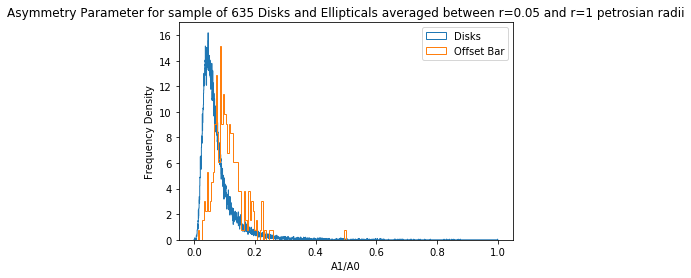

In [66]:
plt.hist(averageover(12,108,alldisks[0]), 2000, density=True,histtype='step', range=(0, 1),label='Disks')
plt.hist(averageover(12,108, offsetbar[0]), 100, density=True,histtype='step', label='Offset Bar')
plt.xlabel('A1/A0')
plt.ylabel('Frequency Density')
plt.title('Asymmetry Parameter for sample of 635 Disks and Ellipticals averaged between r=0.05 and r=1 petrosian radii')
plt.legend()
plt.show()

In [60]:
#Find which range of radii gives biggest separation
maxareabetween3=0
maxstarti3=0
maxendi3=0
maxrmin3=0
maxrmax3=0
rtoprobe=np.arange(0.05,1.3,0.01)
#i is starti, j is endi
for i in range(len(rtoprobe)):
    print(i)
    for j in range(i, len(rtoprobe)):
        diskaverage=averageover(i,j,alldisks[0])
        offsetaverage=averageover(i,j,offsetbar[0])
        if areabetween(diskaverage, offsetaverage)>maxareabetween3:
            maxareabetween3=areabetween(diskaverage, offsetaverage)
            maxrmin3=rtoprobe[i]
            maxrmax3=rtoprobe[j]
            maxstarti3=i
            maxendi3=j
            print(maxrmin3, maxrmax3, maxstarti3, maxendi3, maxareabetween3)
print(maxrmin3, maxrmax3, maxstarti3, maxendi3, maxareabetween3)

0
0.05 0.05 0 0 0.0962335390353
0.05 0.2 0 15 0.113042800261
0.05 0.21 0 16 0.156743269012
0.05 0.24 0 19 0.347890041913
0.05 0.25 0 20 0.355390143456
0.05 0.28 0 23 0.38807360178
0.05 0.33 0 28 0.47997663588
0.05 0.35 0 30 0.481965831654
0.05 0.38 0 33 0.500659816507
0.05 0.46 0 41 0.511993124043
0.05 0.48 0 43 0.522079487364
0.05 0.5 0 45 0.600421499024
0.05 0.54 0 49 0.650374548972
0.05 0.59 0 54 0.665916701323
0.05 0.6 0 55 0.710761562585
0.05 0.7 0 65 0.763773111462
0.05 0.8 0 75 0.797642875984
0.05 0.86 0 81 0.807994596639
0.05 0.9 0 85 0.841480416418
0.05 0.94 0 89 0.86627834011
0.05 0.99 0 94 0.877994968245
0.05 1.01 0 96 0.890702209346
0.05 1.04 0 99 0.905352075457
0.05 1.06 0 101 0.905649552215
1
2
0.07 1.05 2 100 0.913524140316
0.07 1.06 2 101 0.916258660362
3
0.08 1.05 3 100 0.917050651419
0.08 1.08 3 103 0.918247664092
4
5
6
7
8
9
0.14 1.07 9 102 0.919255705087
10
0.15 1.04 10 99 0.923297087196
11
12
0.17 1.13 12 108 0.932478345315
13
14
15
16
17
18
19
20
21
22
23
24
25
26

In [ ]:
alldisks[1][101]

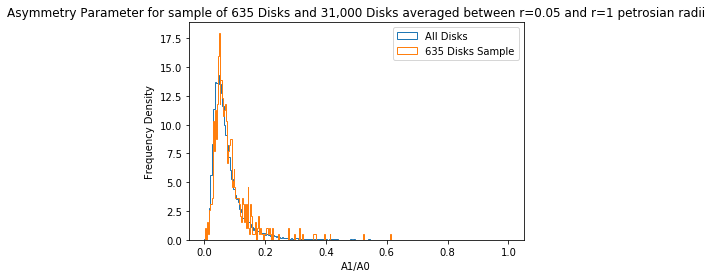

In [73]:
plt.hist(averageover(12,108,alldisks[0]), 200, density=True,histtype='step', range=(0, 1),label='All Disks')
plt.hist(averageover(12,108, disk635[0]), 200, density=True,histtype='step', label='635 Disks Sample')
plt.xlabel('A1/A0')
plt.ylabel('Frequency Density')
plt.title('Asymmetry Parameter for sample of 635 Disks and 31,000 Disks averaged between r=0.05 and r=1 petrosian radii')
plt.legend()
plt.show()